Install packages - In order to use some packages that JupyterLab does not contain, We need to install them at first.

In [3]:
#!pip install minisom
#!pip install rdkit-pypi
#!pip install Mordred

In [4]:
from mordred import Calculator, descriptors
import pandas as pd
import numpy as np
from rdkit import Chem
import re
import minisom
from minisom import MiniSom
import matplotlib.pyplot as plt

### Dataset 'Ampicillin'
This week, we will use the dataset 'Ampicillin' to do the Self-Organizing Map. Ampicillin is a penicillin antibiotic that is used to treat or prevent many different types of infections. 

This dataset contains 1170 organic molecules that are similar to Ampicillin.

In [5]:
df = pd.read_csv("Week9_Hands-On_dataset_Ampicillin.csv")
df.shape

(1170, 24)

In [6]:
df.head()

,cid,cmpdname,cmpdsynonym,mw,mf,polararea,complexity,xlogp,heavycnt,hbonddonor,...,inchikey,iupacname,meshheadings,annothits,annothitcnt,aids,cidcdate,sidsrcname,depcatg,annotation
0,1268,2-[2-(Benzylamino)-2-oxo-1-[(2-phenylacetyl)am...,NaN,441.5,C23H27N3O4S,133.0,645.0,0.1,31,4,...,UDMBRVGTYILYDX-UHFFFAOYSA-N,2-[2-(benzylamino)-2-oxo-1-[(2-phenylacetyl)am...,NaN,Patents,1,NaN,20050325,ABI Chem|ChemDB|ChemSpider|ChemTik|DiscoveryGa...,Chemical Vendors|Legacy Depositors|Research an...,NaN
1,2173,"6-{[Amino(phenyl)acetyl]amino}-3,3-dimethyl-7-...","6-{[amino(phenyl)acetyl]amino}-3,3-dimethyl-7-...",348.4,C16H18N3O4S-,141.0,556.0,-0.5,24,2,...,AVKUERGKIZMTKX-UHFFFAOYSA-M,"6-[(2-amino-2-phenylacetyl)amino]-3,3-dimethyl...",NaN,Biological Test Results,1,1259325,20050325,ABI Chem|AKos Consulting & Solutions|Ambinter|...,Chemical Vendors|Legacy Depositors|Research an...,NaN
2,2174,Alpen,Guicitrine|Ampicin|Deripen|Wypicil|6-{[amino(p...,349.4,C16H19N3O4S,138.0,562.0,-1.1,24,3,...,AVKUERGKIZMTKX-UHFFFAOYSA-N,"6-[(2-amino-2-phenylacetyl)amino]-3,3-dimethyl...",NaN,Biological Test Results|Classification|Literat...,5,1|5|7|9|13|15|19|21|23|25|31|33|35|37|39|41|43...,20050325,001Chemical|AAA Chemistry|abcr GmbH|ABI Chem|A...,Chemical Vendors|Curation Efforts|Governmental...,NaN
3,2271,"3,3-Dimethyl-7-oxo-6-{[{[(2-oxo-1-imidazolidin...",MLS006011456|CHEMBL4747314|DTXSID20860542|BCP1...,461.5,C20H23N5O6S,173.0,844.0,0.1,32,4,...,JTWOMNBEOCYFNV-UHFFFAOYSA-N,"3,3-dimethyl-7-oxo-6-[[2-[(2-oxoimidazolidine-...",NaN,Biological Test Results,1,1259370|1671498,20050325,001Chemical|ABBLIS Chemicals|ABI Chem|AKos Con...,Chemical Vendors|Curation Efforts|Governmental...,NaN
4,2282,1-Ethoxycarbonyloxyethyl 6-[(2-amino-2-phenyla...,CHEMBL1625790|DTXSID20860547|DB-051870|FT-0602...,465.5,C21H27N3O7S,163.0,756.0,2.7,32,2,...,PFOLLRNADZZWEX-UHFFFAOYSA-N,1-ethoxycarbonyloxyethyl 6-[(2-amino-2-phenyla...,NaN,Patents,1,NaN,20050325,001Chemical|ABI Chem|Angel Pharmatech Ltd.|ChE...,Chemical Vendors|Curation Efforts|Governmental...,NaN


In [7]:
df.columns

Index(['cid', 'cmpdname', 'cmpdsynonym', 'mw', 'mf', 'polararea', 'complexity',
       'xlogp', 'heavycnt', 'hbonddonor', 'hbondacc', 'rotbonds', 'inchi',
       'isosmiles', 'inchikey', 'iupacname', 'meshheadings', 'annothits',
       'annothitcnt', 'aids', 'cidcdate', 'sidsrcname', 'depcatg',
       'annotation'],
      dtype='object')

`polararea`:
The polar surface area (PSA) or topological polar surface area (TPSA) of a molecule is defined as the surface sum over all polar atoms or molecules, primarily oxygen and nitrogen, also including their attached hydrogen atoms. 
PSA is a commonly used medicinal chemistry metric for the optimization of a drug's ability to permeate cells. Molecules with a polar surface area of greater than 140 angstroms squared  tend to be poor at permeating cell membranes.

## In this dataset, we can see that we do not have enough data to do machine learning. But actually, we can get lots of data from one column 'isosmiles'. But how?

In this part of hands-on, we focus on the column named `isosmiles`.

The simplified molecular-input line-entry system (SMILES) is a specification in the form of a line notation for describing the structure of chemical species using short ASCII strings. 

For Ampcillin, the SMILES code is CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=CC=C3)N)C(=O)[O-])C

For more information about SMILES, you can read the wikipedia page:
https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system

## RDKit

Build a list of SMILES from the csv file and use rdkit to translate the string to format Mordred can read

In [12]:
df["isosmiles"]

0       CC1(C(NC(S1)C(C(=O)NCC2=CC=CC=C2)NC(=O)CC3=CC=...
1       CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=CC=C3)N)C(=O...
2       CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=CC=C3)N)C(=O...
3       CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=CC=C3)NC(=O)...
4       CCOC(=O)OC(C)OC(=O)C1C(SC2N1C(=O)C2NC(=O)C(C3=...
                              ...                        
1165    CCN1CCN(C(=O)C1=O)C(=O)N[C@H](C2=CC=CC=C2)C(=O...
1166    CC1(C(N2[C@H](S1)CC2=O)(C(=O)O)NC(=O)C(C3=CC=C...
1167    CC1(C(N2C(S1)C(C2=C)NC(=O)C(C3=CC=CC=C3)NC(=O)...
1168    C1[C@@H]2N(C1=O)C(C(S2=O)NC(=O)CC3=CC=CC=C3)C(...
1169    CCCCC(=O)N[C@H](C1=CC=CC=C1)C(=O)N[C@@H]2[C@H]...
Name: isosmiles, Length: 1170, dtype: object

[16:24:56] WARNING: not removing hydrogen atom without neighbors
[16:24:56] WARNING: not removing hydrogen atom without neighbors
[16:24:56] WARNING: not removing hydrogen atom without neighbors
[16:24:56] WARNING: not removing hydrogen atom without neighbors
[16:24:56] WARNING: not removing hydrogen atom without neighbors
[16:24:56] WARNING: not removing hydrogen atom without neighbors
[16:24:56] WARNING: not removing hydrogen atom without neighbors
[16:24:56] WARNING: not removing hydrogen atom without neighbors


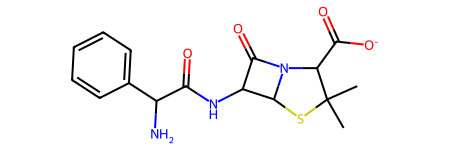

In [8]:
SMILES = []
for molecule in df["isosmiles"]:
    SMILES.append(Chem.MolFromSmiles(molecule))
SMILES[1]#Ampicillin. 
#Why is [1]? It is because the dataset is sorted by cid. (The Pubchem id)

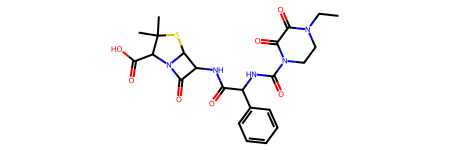

In [43]:
SMILES[10]

In [16]:
len(SMILES)

1170

Why there are so many warining? Because RDkit is a C++ based package, so it is easy to give some errors when run in python environment. 

# Mordred

Specific descriptors can be calculated by calling the appropriate module from the Mordred package

### Chemical Descriptors
Chemical descriptors essentially break a molecule down into numerical values so they can be treated quantitatively to build models for various applications$.^{[1]}$ <br/>
<center><em>"The molecular descriptor is the final result of a logic and mathematical procedure which transforms chemical information encoded within a symbolic representation of a molecule into a useful number or the result of some standardized experiment$"^{[2]}$</em> ~ Roberto Todeschini </center>
<br>
Chemical descriptors can be split up into different dimensions$:^{[3]}$ <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - 0D: bond counts, molecular weight, atom count<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - 1D: fragment count, acceptor-donor bonds<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - 2D: topological properties, connectivity<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - 3D: geometric properties, charged partial surface area<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - 4D: coordinates + conformations <br>

We will be focusing on dimensions 0-2.



In [9]:
mol_id = descriptors.MolecularId.MolecularId() # molecular ID
nAtoms = descriptors.AtomCount.AtomCount() # number of all atoms  
abci = descriptors.ABCIndex.ABCGGIndex() # atom-bond connectivity index
aromatic = descriptors.Aromatic.AromaticAtomsCount() # aromatic atoms count
nARing = descriptors.RingCount.RingCount(None, False, False, True, None) # aromatic ring count
nFARing = descriptors.RingCount.RingCount(None, False, True, True, None) # aromatic fused ring count
frag_cplx = descriptors.FragmentComplexity.FragmentComplexity() # fragment complexity
dist_matrix = descriptors.DistanceMatrix.DistanceMatrix("SpAbs") # graph energy from distance matrix

Mordred descriptor list reference:    
http://mordred-descriptor.github.io/documentation/master/descriptors.html

Let's do some calculations on Ampicillin

In [10]:
mol = SMILES[1]

In [11]:
print(nAtoms(mol))
print(aromatic(mol))
print(frag_cplx(mol))
print(dist_matrix(mol))

42
6
124.08
234.9889721189548


### Exercise 1:
Using the link above, load in other models and calculate new descriptors for Ampicilillin (SMILES[1])

In [35]:
ATS0dv = descriptors.Autocorrelation.ATS(order=1,prop='dv') # autocorrelation of lag 1 weighted by valence e 
VE2_A = descriptors.AdjacencyMatrix.AdjacencyMatrix('VE2') # VE2 of adjacency matrix

In [41]:
VE2_A(SMILES[2])

0.15169530678675855

In [36]:
print(ATS0dv(mol))
print(VE2_A(mol))

328.6666666666667
0.15169530678675855


### We understand what is descriptors and how it works now. Here comes to prepare the datasets.

In [18]:
aromaticA = descriptors.Aromatic.AromaticAtomsCount()
aromaticB = descriptors.Aromatic.AromaticBondsCount()
nARing = descriptors.RingCount.RingCount(None, False, False, True, None)
dist_matrix = descriptors.DistanceMatrix.DistanceMatrix("SpAbs")
nH = descriptors.AtomCount.AtomCount(type='H')
nO = descriptors.AtomCount.AtomCount(type='O')
nN = descriptors.AtomCount.AtomCount(type='N')
nHBA = descriptors.HydrogenBond.HBondAcceptor()
nHBD = descriptors.HydrogenBond.HBondDonor()
SlogP = descriptors.SLogP.SLogP()

In [19]:
descript = [aromaticA, aromaticB, nARing, dist_matrix, nH,nO,nN,nHBA,nHBD,SlogP]

In [20]:
calc = Calculator(descript)
len(calc.descriptors)

10

In [44]:
calc_ALL = Calculator(descriptors)
len(calc_ALL.descriptors)

1826

We can see that there are 1826 descriptors in the Mordred package. Because we have the knowledge about chemistry and material science, we do not need to use them all. That is why the data scientist can not do Chemical or material Analysis.

In [45]:
mordred_df = calc.pandas(SMILES)

 25%|██▍       | 289/1170 [00:07<00:35, 24.86it/s][17:07:53] WARNING: not removing hydrogen atom without neighbors
[17:07:53] WARNING: not removing hydrogen atom without neighbors
 46%|████▋     | 542/1170 [00:14<00:16, 37.98it/s][17:07:59] WARNING: not removing hydrogen atom without neighbors
[17:07:59] WARNING: not removing hydrogen atom without neighbors
 49%|████▉     | 578/1170 [00:15<00:14, 41.54it/s][17:08:00] WARNING: not removing hydrogen atom without neighbors
[17:08:00] WARNING: not removing hydrogen atom without neighbors
 58%|█████▊    | 673/1170 [00:17<00:19, 25.91it/s][17:08:03] WARNING: not removing hydrogen atom without neighbors
[17:08:03] WARNING: not removing hydrogen atom without neighbors
 83%|████████▎ | 974/1170 [00:24<00:04, 45.39it/s][17:08:09] WARNING: not removing hydrogen atom without neighbors
[17:08:09] WARNING: not removing hydrogen atom without neighbors
 94%|█████████▍| 1105/1170 [00:27<00:01, 43.54it/s][17:08:13] WARNING: not removing hydrogen atom wi

In [46]:
mordred_df.head()

,nAromAtom,nAromBond,naRing,SpAbs_D,nH,nO,nN,nHBAcc,nHBDon,SLogP
0,12,12,2,375.757899,27,4,3,5,4,1.9246
1,6,6,1,234.988972,18,4,3,6,2,-1.0166
2,6,6,1,234.988972,19,4,3,5,3,0.3181
3,6,6,1,376.674258,23,6,5,6,4,0.0942
4,6,6,1,420.901187,27,7,3,9,2,1.2958


In [47]:
final_df = pd.concat([df, mordred_df], axis=1)
final_df.head()

,cid,cmpdname,cmpdsynonym,mw,mf,polararea,complexity,xlogp,heavycnt,hbonddonor,...,nAromAtom,nAromBond,naRing,SpAbs_D,nH,nO,nN,nHBAcc,nHBDon,SLogP
0,1268,2-[2-(Benzylamino)-2-oxo-1-[(2-phenylacetyl)am...,NaN,441.5,C23H27N3O4S,133.0,645.0,0.1,31,4,...,12,12,2,375.757899,27,4,3,5,4,1.9246
1,2173,"6-{[Amino(phenyl)acetyl]amino}-3,3-dimethyl-7-...","6-{[amino(phenyl)acetyl]amino}-3,3-dimethyl-7-...",348.4,C16H18N3O4S-,141.0,556.0,-0.5,24,2,...,6,6,1,234.988972,18,4,3,6,2,-1.0166
2,2174,Alpen,Guicitrine|Ampicin|Deripen|Wypicil|6-{[amino(p...,349.4,C16H19N3O4S,138.0,562.0,-1.1,24,3,...,6,6,1,234.988972,19,4,3,5,3,0.3181
3,2271,"3,3-Dimethyl-7-oxo-6-{[{[(2-oxo-1-imidazolidin...",MLS006011456|CHEMBL4747314|DTXSID20860542|BCP1...,461.5,C20H23N5O6S,173.0,844.0,0.1,32,4,...,6,6,1,376.674258,23,6,5,6,4,0.0942
4,2282,1-Ethoxycarbonyloxyethyl 6-[(2-amino-2-phenyla...,CHEMBL1625790|DTXSID20860547|DB-051870|FT-0602...,465.5,C21H27N3O7S,163.0,756.0,2.7,32,2,...,6,6,1,420.901187,27,7,3,9,2,1.2958


In [48]:
final_df.to_csv("Ampicillin_final.csv")

Finally we get the dataset we need to do the SOM.



### In the next part of hands-on, we will focus on the SOM algorithm

# References:
1. https://jcheminf.biomedcentral.com/articles/10.1186/s13321-018-0258-y <br/>
2. https://onlinelibrary.wiley.com/doi/pdf/10.1002/9783527613106.fmatter <br/>
3. https://fiehnlab.ucdavis.edu/staff/kind/chemoinformatics/concepts/descriptors <br/>